# CMR Multi-Parameter Sweep

1. Setup & Parameters (BASE_PARAMS)
2. Simulation Functions
3. Analysis Metrics
4. Visualization Functions
5. Sweep Function
6. Sweeps (B_rec, gamma_fc, eta, B_encD_scale)

---
## Setup

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)


### List Configuration

In [40]:
# List length and presentation order
N = 10
pres_indices = np.random.permutation(N) + 1  # 1-indexed

# Sequence values (not used in basic CMR)
sequence = np.array([50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45])

### Base Parameters

`BASE_PARAMS` contains defaults for all sweepable parameters.

In [41]:
# === Base Parameters (defaults when NOT sweeping) ===
BASE_PARAMS = {
    "B_rec": 0.55,              # Retrieval context drift
    "gamma_fc": 0.581,          # Pre-existing association strength
    "eta": 0.3699,              # Accumulator noise
    "B_encD_scale": 1.0,        # Encoding drift multiplier
}

# === Parameter Grids for Sweeping ===
B_rec_grid = [0.10, 0.25, 0.40, 0.55, 0.70, 0.85]
gamma_fc_grid = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eta_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
B_encD_scale_grid = [0.6, 0.8, 1.0, 1.2, 1.4]

# Reproducibility
BASE_SEED = 2026
n_sims = 500


### Retrieval Route Weights

In [42]:
# Balance between semantic and episodic retrieval
sem = 0
episodic = 1

sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)


### Context Drift & Semantic Matrix

In [43]:
# Encoding drift schedule
B_encD = np.array([1.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

# Semantic matrix (orthogonal items)
sem_mat = np.eye(N)


### Fixed Parameters

In [44]:
# These remain constant across all sweeps
lrate_cf_enc = 1.0
lrate_fc_rec = 0.0
lrate_cf_rec = 0.0

# Accumulator dynamics
thresh = 1.0
rec_time = 90000  # ms
dt = 100          # ms
tau = 413         # ms
K = 0.091
L = 0.375

---
## Simulation (Parameterized)

Accepts `gamma_fc_val`, `eta_val`, `B_encD_scale` as optional parameters.

In [45]:
def simulate_single_trial(B_rec, rng, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0, record_diagnostics=False):
    """
    Simulate one encoding-retrieval trial.
    
    Parameters
    ----------
    B_rec : float
        Context drift rate during retrieval
    rng : numpy.random.Generator
        Random number generator
    gamma_fc_val : float, optional
        Pre-existing association strength (if None, uses global gamma_fc from BASE_PARAMS)
    eta_val : float, optional
        Accumulator noise (if None, uses global eta from BASE_PARAMS)
    B_encD_scale : float, optional
        Multiplier for encoding drift schedule
    record_diagnostics : bool
        Record cue advantage diagnostics
    
    Returns
    -------
    recalls, times, net_w_fc, net_w_cf, diagnostics
    """
    
    # === Use provided values or fall back to BASE_PARAMS ===
    if gamma_fc_val is None:
        gamma_fc_val = BASE_PARAMS["gamma_fc"]
    if eta_val is None:
        eta_val = BASE_PARAMS["eta"]
    
    # === Derived parameters (recomputed if gamma_fc changes) ===
    eye_fc_local = 1.0 - gamma_fc_val
    eye_cf_local = 0.0
    lrate_fc_enc_local = gamma_fc_val
    
    # === Scale encoding drift ===
    B_encD_local = B_encD * B_encD_scale
    
    # ========== INITIALIZATION ==========
    net_f = np.zeros((N, 1))
    net_c = np.zeros((N, 1))
    
    # Initialize weights with pre-existing associations
    net_w_fc = np.eye(N) * eye_fc_local
    net_w_cf = np.eye(N) * eye_cf_local
    
    # ========== ENCODING PHASE ==========
    for item_idx in range(N):
        feature_idx = pres_indices[item_idx] - 1
        
        net_f = np.zeros((N, 1))
        net_f[feature_idx] = 1
        
        # Context input through M_FC
        net_c_in = net_w_fc @ net_f
        net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
        
        # Context update
        c_in, c = net_c_in, net_c
        B = B_encD_local[item_idx]
        dot = float(c.T @ c_in)
        rho = np.sqrt(1 + (B**2) * ((dot**2) - 1)) - B * dot
        net_c = rho * c + B * c_in
        
        # Weight updates
        net_w_fc += (net_c @ net_f.T) * lrate_fc_enc_local
        net_w_cf += (net_f @ net_c.T) * lrate_cf_enc
    
    # ========== RETRIEVAL SETUP ==========
    recalls = np.zeros((N, 1))
    times = np.zeros((N, 1))
    retrieved = np.zeros((N, 1), dtype=bool)
    thresholds = np.ones((N, 1))
    
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat
    
    time_passed = 0
    recall_count = 0
    
    # Diagnostics
    if record_diagnostics:
        deltas_all = []
        deltas_by_pos = defaultdict(list)
        delta_forward = []
        delta_backward = []
        pending = None
    
    # ========== RETRIEVAL LOOP ==========
    while time_passed < rec_time:
        
        f_in = net_weights @ net_c
        
        max_cycles = int((rec_time - time_passed) / dt)
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau)
        
        # Pre-generate noise (use eta_val, not global eta)
        noise = rng.normal(0, eta_val * sq_dt_tau, size=(N, max_cycles))
        
        eyeI = ~np.eye(N, dtype=bool)
        lmat = eyeI.astype(float) * L
        
        x = np.zeros((N, 1))
        K_array = np.ones((N, 1)) * K
        inds = np.arange(N)
        
        crossed = 0
        i = 0
        
        while i < max_cycles and crossed == 0:
            
            lx = lmat @ x
            kx = K_array * x
            
            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0
            
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]
            
            retrievable = ~retrieved
            
            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                
                if len(winners) > 1:
                    winners = np.array([rng.choice(winners)])
            
            i += 1
        
        time_passed += i * dt
        
        if crossed == 1:
            winner = int(winners[0])
            serial_pos0 = np.where(pres_indices - 1 == winner)[0][0]
            serial_pos1 = serial_pos0 + 1
            
            # Diagnostics
            if record_diagnostics and pending is not None:
                prev_pos0 = pending["serial_pos0"]
                delta_f_prev = pending["delta_f"]
                transition = serial_pos0 - prev_pos0
                
                if transition == 1:
                    delta_forward.append(delta_f_prev)
                elif transition == -1:
                    delta_backward.append(delta_f_prev)
                
                pending = None
            
            # Reactivate
            net_f = np.zeros((N, 1))
            net_f[winner] = 1
            
            # Context update
            net_c_in = net_w_fc @ net_f
            net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
            
            c_in, c = net_c_in, net_c
            dot = float(c.T @ c_in)
            rho = np.sqrt(1 + (B_rec**2) * ((dot**2) - 1)) - B_rec * dot
            net_c = rho * c + B_rec * c_in
            
            net_w_fc += (net_c @ net_f.T) * lrate_fc_rec
            net_w_cf += (net_f @ net_c.T) * lrate_cf_rec
            
            recall_count += 1
            recalls[recall_count - 1, 0] = serial_pos1
            times[recall_count - 1, 0] = time_passed
            
            # Cue advantage
            if record_diagnostics:
                left_pos0 = serial_pos0 - 1
                right_pos0 = serial_pos0 + 1
                
                if 0 <= left_pos0 < N and 0 <= right_pos0 < N:
                    left_item = pres_indices[left_pos0] - 1
                    right_item = pres_indices[right_pos0] - 1
                    
                    if (not retrieved[left_item]) and (not retrieved[right_item]):
                        f_after = (net_weights @ net_c).flatten()
                        delta_f = f_after[right_item] - f_after[left_item]
                        
                        deltas_all.append(delta_f)
                        deltas_by_pos[serial_pos1].append(delta_f)
                        pending = {"serial_pos0": serial_pos0, "delta_f": delta_f}
            
            retrieved[winner] = True
    
    diagnostics = None
    if record_diagnostics:
        diagnostics = {
            "deltas_all": deltas_all,
            "deltas_by_pos": dict(deltas_by_pos),
            "delta_forward": delta_forward,
            "delta_backward": delta_backward
        }
    
    return recalls.flatten(), times.flatten(), net_w_fc, net_w_cf, diagnostics

---
## Batch Runner (Parameterized)

In [46]:
def run_simulation(B_rec, n_sims=500, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """
    Run multiple independent trials.
    
    Parameters
    ----------
    B_rec : float
        Retrieval context drift
    n_sims : int
        Number of simulations
    seed : int
        Random seed
    gamma_fc_val : float, optional
        Pre-existing association strength
    eta_val : float, optional
        Accumulator noise
    B_encD_scale : float, optional
        Encoding drift multiplier
    
    Returns
    -------
    recall_sims, times_sims, net_w_fc, net_w_cf
    """
    rng = np.random.default_rng(seed)
    
    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims = np.zeros((N, n_sims), dtype=float)
    
    net_w_fc_last = None
    net_w_cf_last = None
    
    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, _ = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=False
        )
        
        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s] = times
        
        net_w_fc_last = net_w_fc
        net_w_cf_last = net_w_cf
    
    return recall_sims, times_sims, net_w_fc_last, net_w_cf_last

---
## Analysis Metrics

In [47]:
def compute_spc(recall_sims, N):
    """Serial Position Curve."""
    spc = np.zeros(N)
    for j in range(1, N + 1):
        spc[j - 1] = np.mean(np.any(recall_sims == j, axis=0))
    return spc


def compute_pfr(recall_sims, N):
    """Probability of First Recall."""
    first = recall_sims[0, :]
    first = first[first > 0]
    
    pfr = np.zeros(N)
    if len(first) > 0:
        for j in range(1, N + 1):
            pfr[j - 1] = np.mean(first == j)
    return pfr


def compute_lag_crp(recall_sims, N):
    """Lag-CRP with opportunity correction."""
    max_lag = N - 1
    lag_vals = np.arange(-max_lag, max_lag + 1)
    
    numer = np.zeros(len(lag_vals), dtype=float)
    denom = np.zeros(len(lag_vals), dtype=float)
    
    lag_to_idx = {L: i for i, L in enumerate(lag_vals)}
    
    for s in range(recall_sims.shape[1]):
        seq = recall_sims[:, s]
        seq = seq[seq > 0].astype(int)
        
        if len(seq) < 2:
            continue
        
        recalled = set()
        
        for t in range(len(seq) - 1):
            cur = seq[t]
            nxt = seq[t + 1]
            
            recalled.add(cur)
            remaining = [j for j in range(1, N + 1) if j not in recalled]
            
            for j in remaining:
                L = j - cur
                denom[lag_to_idx[L]] += 1
            
            L_obs = nxt - cur
            numer[lag_to_idx[L_obs]] += 1
    
    crp = np.zeros_like(numer)
    valid = denom > 0
    crp[valid] = numer[valid] / denom[valid]
    
    return lag_vals, crp


def compute_cue_diagnostics(B_rec, n_sims=500, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """Compute neighbor cue advantage diagnostics."""
    rng = np.random.default_rng(seed)
    
    deltas_all = []
    deltas_by_pos = defaultdict(list)
    delta_forward = []
    delta_backward = []
    
    for s in range(n_sims):
        _, _, _, _, diag = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=True
        )
        
        if diag is not None:
            deltas_all.extend(diag["deltas_all"])
            delta_forward.extend(diag["delta_forward"])
            delta_backward.extend(diag["delta_backward"])
            
            for k, v in diag["deltas_by_pos"].items():
                deltas_by_pos[k].extend(v)
    
    return {
        "deltas_all": deltas_all,
        "deltas_by_pos": dict(deltas_by_pos),
        "delta_forward": delta_forward,
        "delta_backward": delta_backward
    }

---
## Visualization Functions

In [48]:
def plot_spc_sweep(sweep_results, param_grid, param_name="Parameter"):
    """Plot Serial Position Curves."""
    plt.figure(figsize=(8, 5))
    
    serial_labels = np.arange(1, N + 1)
    
    for param_val in param_grid:
        spc = sweep_results[param_val]["SPC"]
        plt.plot(serial_labels, spc, marker="o", label=f"{param_name}={param_val:.2f}")
    
    plt.title(f"Serial Position Curve across {param_name}")
    plt.xlabel("Serial Position")
    plt.ylabel("P(Recall)")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_pfr_sweep(sweep_results, param_grid, param_name="Parameter"):
    """Plot Probability of First Recall."""
    plt.figure(figsize=(8, 5))
    
    serial_labels = np.arange(1, N + 1)
    
    for param_val in param_grid:
        pfr = sweep_results[param_val]["PFR"]
        plt.plot(serial_labels, pfr, marker="o", label=f"{param_name}={param_val:.2f}")
    
    plt.title(f"Probability of First Recall across {param_name}")
    plt.xlabel("Serial Position")
    plt.ylabel("P(First Recall)")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_lag_crp_sweep(sweep_results, param_grid, param_name="Parameter"):
    """Plot Lag-CRP curves."""
    plt.figure(figsize=(8, 5))
    
    for param_val in param_grid:
        recall_sims = sweep_results[param_val]["recall_sims"]
        lag_vals, crp = compute_lag_crp(recall_sims, N)
        
        neg = lag_vals < 0
        pos = lag_vals > 0
        
        line, = plt.plot(lag_vals[neg], crp[neg], marker="o", 
                        label=f"{param_name}={param_val:.2f}")
        plt.plot(lag_vals[pos], crp[pos], marker="o", color=line.get_color())
    
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(f"Lag-CRP across {param_name}")
    plt.xlabel("Lag (next − current)")
    plt.ylabel("CRP")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## Sweep Function

### Sweep ANY parameter while holding others at their BASE_PARAMS values.

In [49]:
def sweep_one_param(param_name, param_grid, base_params, n_sims=500, base_seed=2026, verbose=True):
    """
    Sweep exactly one parameter while holding others fixed.
    
    Parameters
    ----------
    param_name : str
        Name of parameter to sweep ("B_rec", "gamma_fc", "eta", "B_encD_scale")
    param_grid : list
        Values to test
    base_params : dict
        Default values for all parameters
    n_sims : int
        Simulations per condition
    base_seed : int
        Random seed (incremented for each condition)
    verbose : bool
        Print progress
    
    Returns
    -------
    sweep_results : dict
        Results keyed by parameter value
    """
    sweep_results = {}
    
    if verbose:
        print(f"Sweeping {param_name}: {len(param_grid)} conditions × {n_sims} sims")
    
    for idx, val in enumerate(param_grid):
        if verbose:
            print(f"  [{idx+1}/{len(param_grid)}] {param_name} = {val:.3f}")
        
        # Build params for this condition
        params = base_params.copy()
        params[param_name] = float(val)
        
        seed = base_seed + idx
        
        # Run simulation
        recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
            B_rec=params["B_rec"],
            n_sims=n_sims,
            seed=seed,
            gamma_fc_val=params["gamma_fc"],
            eta_val=params["eta"],
            B_encD_scale=params["B_encD_scale"],
        )
        
        # Compute metrics
        spc = compute_spc(recall_sims, N)
        pfr = compute_pfr(recall_sims, N)
        lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
        
        # Diagnostics (use fewer sims to save time)
        diag = compute_cue_diagnostics(
            B_rec=params["B_rec"],
            n_sims=min(200, n_sims // 5),
            seed=seed,
            gamma_fc_val=params["gamma_fc"],
            eta_val=params["eta"],
            B_encD_scale=params["B_encD_scale"],
        )
        
        # Store results
        sweep_results[val] = {
            "params": params,
            "recall_sims": recall_sims,
            "times_sims": times_sims,
            "SPC": spc,
            "PFR": pfr,
            "lag_vals": lag_vals,
            "lag_probs": lag_probs,
            "net_w_fc": net_w_fc,
            "net_w_cf": net_w_cf,
            "cue_diag": diag
        }
    
    if verbose:
        print(f"\nSweep complete!\n")
    
    return sweep_results

---
### Sweep across retrieval context drift values.

In [50]:
sweep_B_rec = sweep_one_param(
    param_name="B_rec",
    param_grid=B_rec_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

Sweeping B_rec: 6 conditions × 500 sims
  [1/6] B_rec = 0.100
  [2/6] B_rec = 0.250
  [3/6] B_rec = 0.400
  [4/6] B_rec = 0.550
  [5/6] B_rec = 0.700
  [6/6] B_rec = 0.850

Sweep complete!



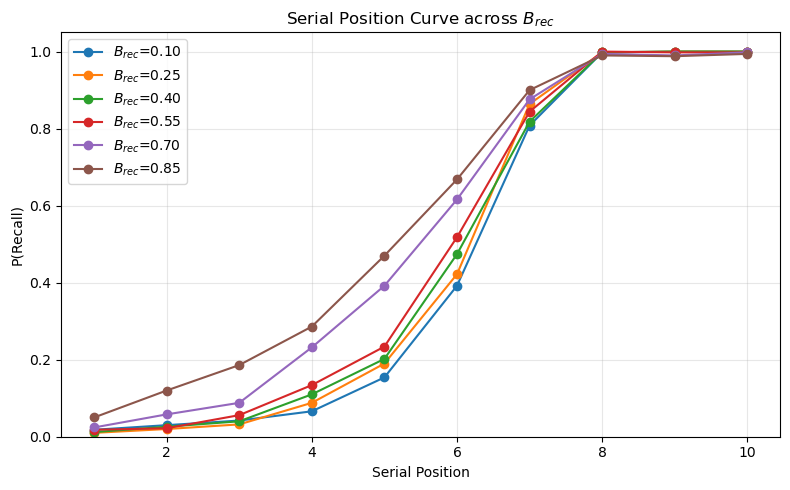

In [51]:
plot_spc_sweep(sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$")

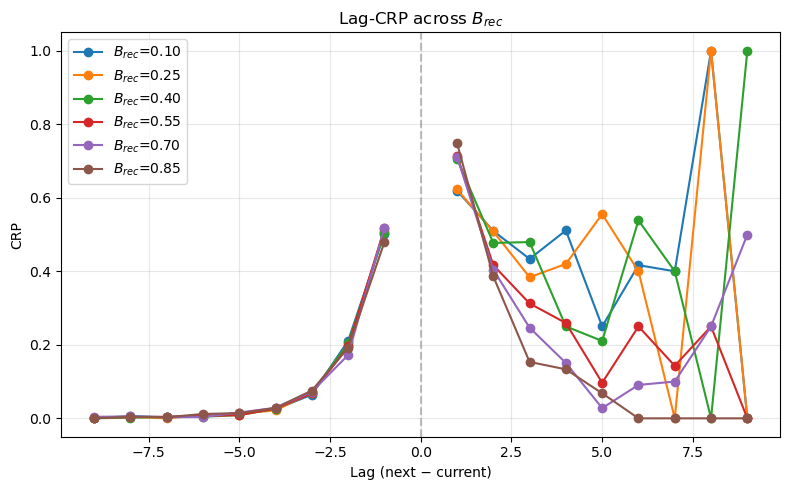

In [52]:
plot_lag_crp_sweep(sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$")

---
### Sweep strength of feature-context associations.

In [53]:
sweep_gamma_fc = sweep_one_param(
    param_name="gamma_fc",
    param_grid=gamma_fc_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

Sweeping gamma_fc: 7 conditions × 500 sims
  [1/7] gamma_fc = 0.200
  [2/7] gamma_fc = 0.300
  [3/7] gamma_fc = 0.400
  [4/7] gamma_fc = 0.500
  [5/7] gamma_fc = 0.600
  [6/7] gamma_fc = 0.700
  [7/7] gamma_fc = 0.800

Sweep complete!



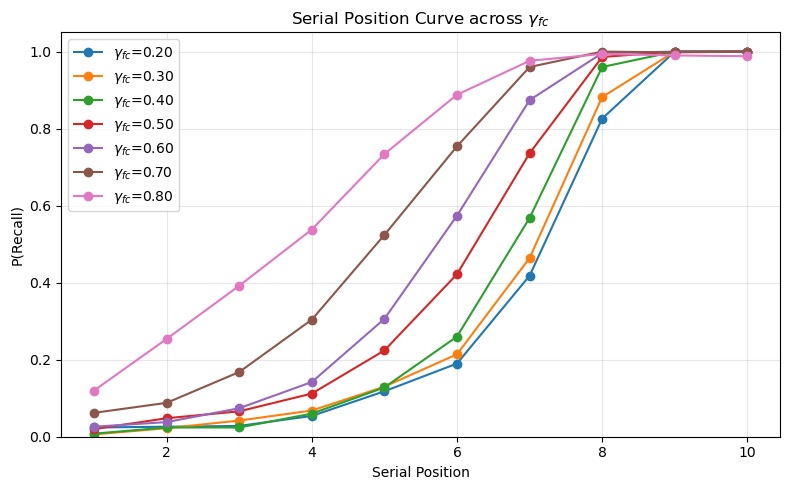

In [54]:
plot_spc_sweep(sweep_gamma_fc, gamma_fc_grid, param_name=r"$\gamma_{fc}$")

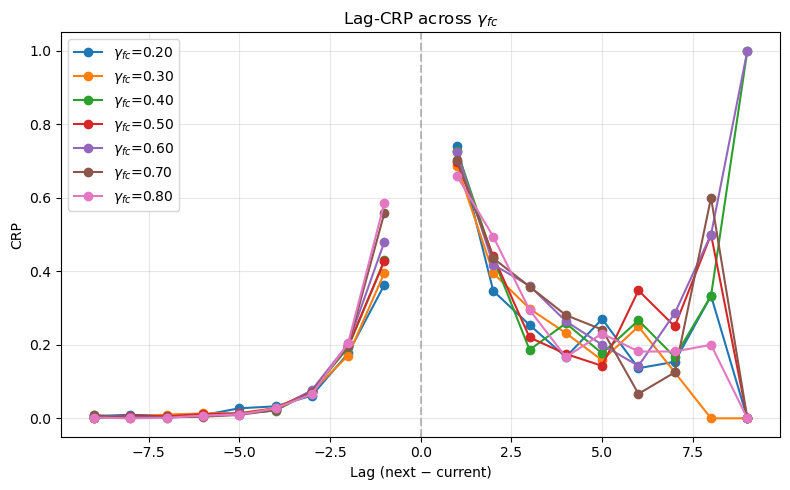

In [55]:
plot_lag_crp_sweep(sweep_gamma_fc, gamma_fc_grid, param_name=r"$\gamma_{fc}$")

---
### Sweep noise level in the decision accumulator.

In [56]:
sweep_eta = sweep_one_param(
    param_name="eta",
    param_grid=eta_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

Sweeping eta: 6 conditions × 500 sims
  [1/6] eta = 0.100
  [2/6] eta = 0.200
  [3/6] eta = 0.300
  [4/6] eta = 0.400
  [5/6] eta = 0.500
  [6/6] eta = 0.600

Sweep complete!



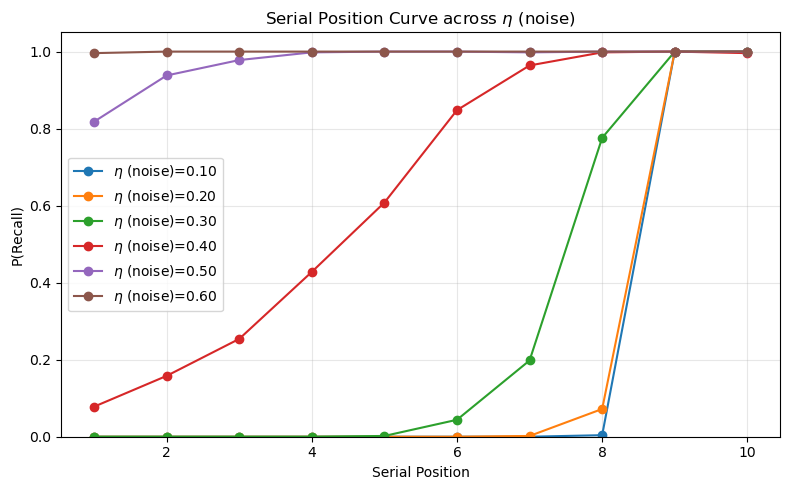

In [57]:
plot_spc_sweep(sweep_eta, eta_grid, param_name=r"$\eta$ (noise)")

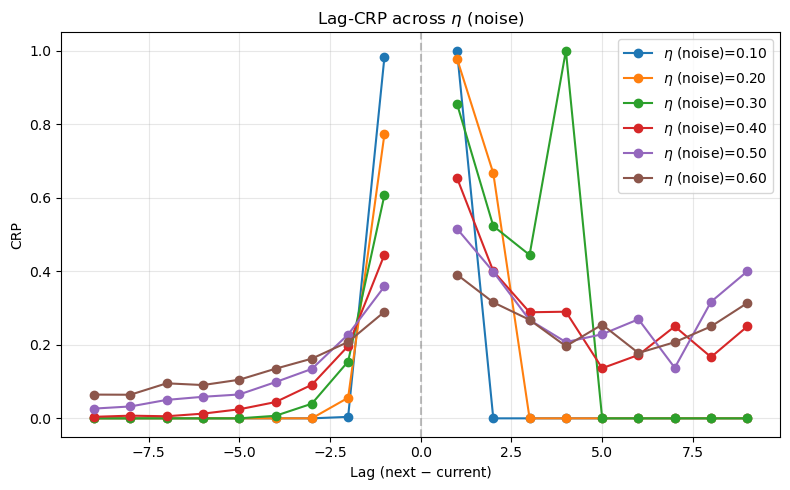

In [58]:
plot_lag_crp_sweep(sweep_eta, eta_grid, param_name=r"$\eta$ (noise)")

---

### Sweep overall strength of encoding context drift.

In [59]:
sweep_B_enc_scale = sweep_one_param(
    param_name="B_encD_scale",
    param_grid=B_encD_scale_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

Sweeping B_encD_scale: 5 conditions × 500 sims
  [1/5] B_encD_scale = 0.600
  [2/5] B_encD_scale = 0.800
  [3/5] B_encD_scale = 1.000
  [4/5] B_encD_scale = 1.200
  [5/5] B_encD_scale = 1.400

Sweep complete!



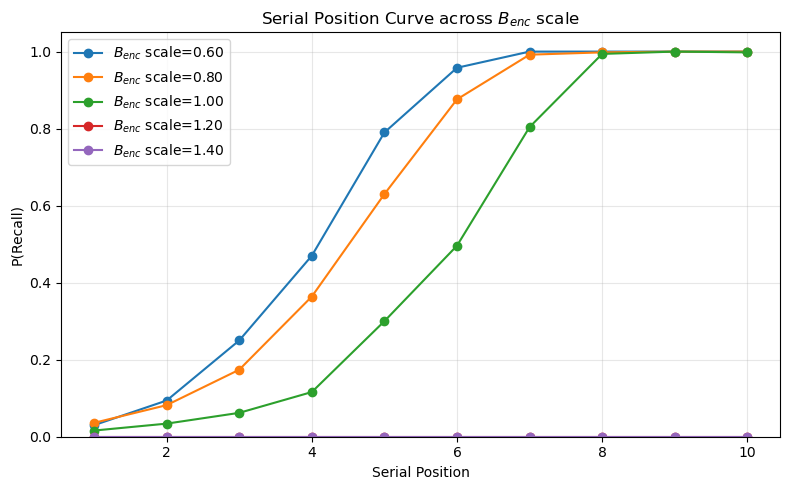

In [60]:
plot_spc_sweep(sweep_B_enc_scale, B_encD_scale_grid, param_name=r"$B_{enc}$ scale")

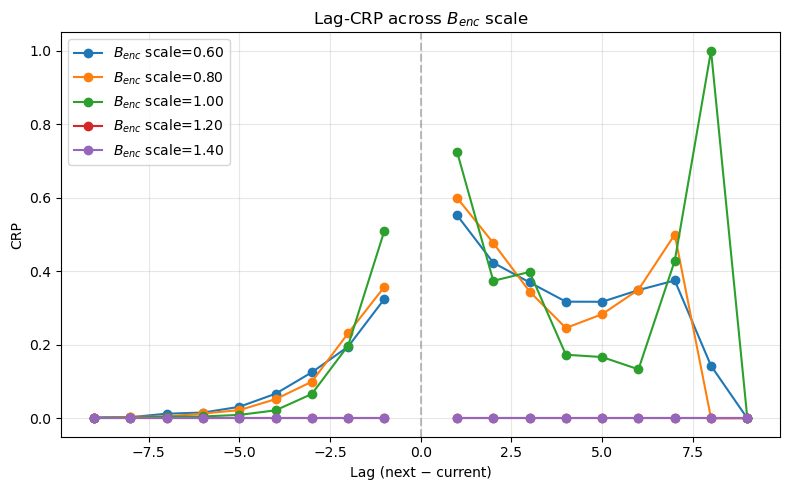

In [61]:
plot_lag_crp_sweep(sweep_B_enc_scale, B_encD_scale_grid, param_name=r"$B_{enc}$ scale")

---
### To Sweep a New Parameter

```python
# 1. Add to BASE_PARAMS if needed
BASE_PARAMS["new_param"] = default_value

# 2. Add grid
new_param_grid = [val1, val2, val3]

# 3. Modify simulate_single_trial to accept it
def simulate_single_trial(B_rec, rng, new_param_val=None, ...):
    if new_param_val is None:
        new_param_val = BASE_PARAMS["new_param"]
    # Use new_param_val in simulation...

# 4. Run sweep
sweep_results = sweep_one_param("new_param", new_param_grid, BASE_PARAMS)
```